In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mplleaflet as mpl
from ipyleaflet import *
from ipywidgets import Layout
import os
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import pyodbc
from pyproj import Proj, transform

%matplotlib inline

In [2]:
#find working folder
dir_path = os.getcwd()

In [3]:
# connection to server and databse
conn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=SQL1\\LIVE1;"
                      "Database=CommonData;"
                      "Trusted_Connection=yes;")
# Read the sql file
query = open(dir_path + '/' + 'ers_failures.sql', 'r')

In [4]:
# read the sql query and connection and create a dataframe
df = pd.read_sql(query.read(), conn)

In [5]:
# convert x/y columns to number from text
df['EASTING'] = df['EASTING'].apply(lambda x: int(x))
df['NORTHING'] = df['NORTHING'].apply(lambda x: int(x))
#df[["EASTING", "NORTHING"]] = df[["EASTING", "NORTHING"]].apply(pd.to_numeric)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   INCIDENT_NUMBER  921 non-null    object        
 1   CALL_TIME        921 non-null    datetime64[ns]
 2   FINANCIAL_YEAR   921 non-null    object        
 3   ERS_TYPE         921 non-null    object        
 4   EASTING          921 non-null    int64         
 5   NORTHING         921 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 43.3+ KB
None


In [6]:
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy", towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")

#def dfENtoLL84(df):
#    vlon36, vlat36 = vgrid(df["EASTING"].values, df["NORTHING"].values, inverse=True)
#    result = transform(v36, v84, vlon36, vlat36)
#    # Transform the output to a Dataframe
#    latlong = pd.DataFrame(index=df.index)
#    for i in result:
#        latlong["lon"] = result[0]
#        latlong["lat"] = result[1]
#    return latlong

def vectorized_convert(df):
    vlon36, vlat36 = vgrid(df['EASTING'].values,df['NORTHING'].values,inverse=True)
    converted = transform(v36, v84, vlon36, vlat36)
    df['lat'] = converted[0]
    df['lon'] = converted[1]
    return df

#df2 = pd.DataFrame({'NORTHING': [378778, 384732],'EASTING': [366746, 364758]})
vec = vectorized_convert(df)
print(vec)
#vec.to_csv("dd.csv", index=False)

       INCIDENT_NUMBER               CALL_TIME FINANCIAL_YEAR  ERS_TYPE  \
0    HV009469-26062019 2019-06-26 13:47:17.763        2019/20  DWELLING   
1    HV023576-11102019 2019-10-11 11:40:41.870        2019/20  DWELLING   
2    TV005869-15062018 2018-06-15 08:08:41.607        2018/19       RTC   
3    TV029814-01012020 2020-01-01 00:15:15.847        2019/20  DWELLING   
4    VV000071-01042018 2018-04-01 17:38:38.790        2018/19       RTC   
..                 ...                     ...            ...       ...   
916  VV038422-28032019 2019-03-28 18:25:32.883        2018/19  DWELLING   
917  VV038453-29032019 2019-03-29 01:33:37.527        2018/19  DWELLING   
918  VV038720-15032020 2020-03-15 18:41:17.693        2019/20       RTC   
919  VV039318-22032020 2020-03-22 17:02:38.913        2019/20  DWELLING   
920  VW031041-26122019 2019-12-26 07:15:28.510        2019/20       RTC   

     EASTING  NORTHING       lat        lon  
0     245363    118720 -4.202679  50.947119  
1     3

C:\Users\ppearson\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\ppearson\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\ppearson\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. See: 

In [7]:
inProj, outProj = Proj('epsg:27700'), Proj('epsg:4326')

def vectorized_convert(df):
    converted = transform(inProj, outProj , df['EASTING'].tolist(), df['NORTHING'].tolist())
    df['lat'] = converted[1]
    df['lon'] = converted[0]
    return df
vec = vectorized_convert(df)
print(vec)

       INCIDENT_NUMBER               CALL_TIME FINANCIAL_YEAR  ERS_TYPE  \
0    HV009469-26062019 2019-06-26 13:47:17.763        2019/20  DWELLING   
1    HV023576-11102019 2019-10-11 11:40:41.870        2019/20  DWELLING   
2    TV005869-15062018 2018-06-15 08:08:41.607        2018/19       RTC   
3    TV029814-01012020 2020-01-01 00:15:15.847        2019/20  DWELLING   
4    VV000071-01042018 2018-04-01 17:38:38.790        2018/19       RTC   
..                 ...                     ...            ...       ...   
916  VV038422-28032019 2019-03-28 18:25:32.883        2018/19  DWELLING   
917  VV038453-29032019 2019-03-29 01:33:37.527        2018/19  DWELLING   
918  VV038720-15032020 2020-03-15 18:41:17.693        2019/20       RTC   
919  VV039318-22032020 2020-03-22 17:02:38.913        2019/20  DWELLING   
920  VW031041-26122019 2019-12-26 07:15:28.510        2019/20       RTC   

     EASTING  NORTHING       lat        lon  
0     245363    118720 -4.202679  50.947119  
1     3

C:\Users\ppearson\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.


In [8]:
coords = vec[['lat', 'lon']].values
miles = 2
conversion_factor = 0.62137119
kilometers = miles / conversion_factor
kms_per_radian = 6371.0088
epsilon = kilometers / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=12, metric='haversine', algorithm='ball_tree').fit(np.radians(coords))
cluster_labels = db.labels_
#print(cluster_labels)

In [9]:
# calculate the number of clusters
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters: {}'.format(num_clusters))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print(clusters)
# identify core points
core_points = np.zeros_like(cluster_labels, dtype = bool)
core_points[db.core_sample_indices_] = True
#print(core_points)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(coords, cluster_labels))

Number of clusters: 7
0    [[-2.945558441726794, 51.23744538894077], [-2....
1    [[-3.6518203950564305, 50.51049233612191], [-3...
2    [[-3.5161100671119274, 50.46373782748626], [-3...
3    [[-3.6866836647381134, 50.43006440795513], [-3...
4    [[-4.174912779334636, 50.389848989404605], [-4...
5    [[-4.042645153505853, 50.380537480849995], [-4...
6    [[-3.5013258725719703, 50.72647567256655], [-3...
dtype: object
Silhouette Coefficient: -0.436


In [10]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
#print(centermost_points)
#centermost_points.to_csv("centre.csv", index=False)
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lat':lats, 'lon':lons})
rs = rep_points
#rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) &amp;&amp; (df['lon']==row['lon'])].iloc[0], axis=1)

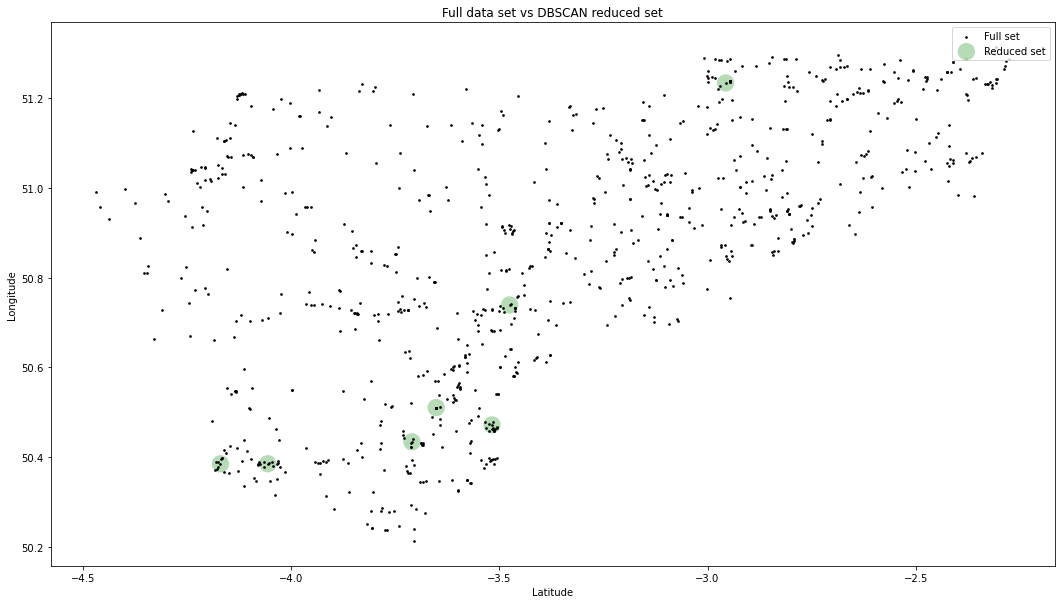

In [11]:
fig, ax = plt.subplots(figsize=[18, 10])
rs_scatter = ax.scatter(rs['lat'], rs['lon'], c='#99cc99', edgecolor='None', alpha=0.7, s=300)
df_scatter = ax.scatter(df['lat'], df['lon'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [12]:
## make the figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

## plot ride data
plt.plot(rs['lat'], rs['lon'], 'or', alpha = .5, markersize=20)

## display the Leaflet
# mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets

C:\Users\ppearson\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [13]:
gdf = gpd.GeoDataFrame(rs, geometry=gpd.points_from_xy(rs['lat'], rs['lon']))

geo_data = GeoData(geo_dataframe = gdf,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

In [14]:
defaultlayout=Layout(width='960px', height='540px')
center=[50.909614, -3.48]
zoom=8
m=Map(center=center, zoom=zoom, basemap=basemaps.CartoDB.Positron, layout=defaultlayout)
m.add_layer(geo_data)
m.add_control(LayersControl())
m

Map(center=[50.909614, -3.48], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [44]:
import folium
# Build map 
m = folium.Map(location=(50.909614, -3.48), zoom_start=9, tiles='cartodbpositron', width=980, height=580)

# I can add marker one by one on the map
for i in range(0,len(rs)):
   folium.Circle(
      location=[rs.iloc[i]['lon'], rs.iloc[i]['lat']],
      #popup=data.iloc[i]['name'],
      radius = 100,
      #radius=data.iloc[i]['value']*10000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

#folium.RegularPolygonMarker(rs[lat, lon], popup='name', fill_color='blue', number_of_sides= 3, radius=pixels ).add_to(m)

sw = rs[['lon', 'lat']].min().values.tolist()
ne = rs[['lon', 'lat']].max().values.tolist()

m.fit_bounds([sw, ne]) 
m

In [18]:
import folium
# Build map 
m = folium.Map(location=(50.909614, -3.48), zoom_start=9, tiles='cartodbpositron', width=980, height=580)

# I can add marker one by one on the map
for i in range(0,len(rs)):
   folium.CircleMarker(location=[rs.iloc[i]['lon'], rs.iloc[i]['lat']], color='crimson', fill=True,
      fill_color='crimson', fillOpacity= 0.8, radius=20, weight=0).add_to(m)
m